In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import networkx as nx
from scipy.sparse import csr_matrix
from sklearn.linear_model import RidgeClassifier
from scipy import ndimage
from keras.datasets import mnist
from hilbert import decode, encode
from sklearn.metrics import confusion_matrix
import scipy.cluster.hierarchy as spc
import seaborn as sns


In [2]:
"""
Define Coupled Oscillator Class
"""

class CoupledOscillator():
    def __init__(self, n_rings = 200, ring_sizes = (3,10), eps = 0.25, p = 0.2, n_in = 8, dt = 1e-2, T_sim  = 100, seed = -1, v_thl = 0.2, v_thh = 0.49, dv = 1e-2, dt_init = 1e-3):
        self.T_init_max = 2 * ring_sizes[1]
        # Network parameters
        self.ring_sizes = ring_sizes # (min, max) Number of neurons per ring
        self.n_rings = n_rings # Number of rings in the network
        self.eps = eps # Coupling constant
        self.p = p #Frequency of random connection for small worlds graph
        self.n_in = n_in #Size of the sliding bit window

        # Simulation parameters
        self.dt = dt # Simulation timestep
        self.T_sim = T_sim  # Simulation duration
        self.seed = seed # Random seed for the simulation

        # Neuron parameters
        self.v_thl = v_thl # Lower threshold of the schmidt trigger
        self.v_thh = v_thh # Upper threshold of the schmidt trigger

        self.dv = dv # Controls the randomness in the initial state
        self.dt_init = dt_init

        if self.seed == -1: self.seed = np.random.randint(1e6)
        print('Random Seed:', self.seed)
        np.random.seed(self.seed)

        # Generating the ring sizes
        self.R = np.random.choice(np.arange(ring_sizes[0], ring_sizes[1]+1), size=n_rings)
        unique, counts = np.unique(self.R, return_counts=True)
        print("Ring Sizes: " + str(dict(zip(unique, counts))))

        self.n_h = self.R.sum() # Total number of neurons
        # Idx associated with the first neuron in each ring
        self.nrn1_idx = np.insert(self.R[:-1].cumsum(), 0, 0)
        # Shifted ring indices
        self.shifted_idx = np.concatenate(
            [
                np.roll(np.arange(r_i) + self.nrn1_idx[i], 1)
                for (i,r_i) in enumerate(self.R)
            ]
        )

        #Watts Strogatz Small World Graph
        G = nx.watts_strogatz_graph(n = n_rings, k = 2, p = p)
        self.W = nx.to_numpy_array(G) * self.eps

        # Setup arrays to store the simulation history
        self.n_ts = int(T_sim / dt) + 1 # Number of timesteps in the simulation
        self.v_cap = np.empty((self.n_ts,self.n_h), dtype=float)
        self.v_out = np.empty((self.n_ts,self.n_h), dtype=float)


        #Generate adjacency matrix describing input (W_in)
        W_in = np.random.binomial(1, p, size = (n_rings, n_in))
        np.fill_diagonal(W_in, 0)

        W_in_expanded = np.zeros((self.n_h,n_in), dtype=int)
        # Iterate through each outgoing ring (i) and target ring (j) for the input
        for i in range(n_rings):
            for j in range(n_in):
                # Get the indices for the first neuron in the outgoing ring (i) and the second neuron in the target ring (j)
                first_neuron_idx_i = self.nrn1_idx[i]

                # Get the connection strength from W
                connection_strength = W_in[i, j]

                # Set the connection in W_comb
                if connection_strength > 0:
                    W_in_expanded[first_neuron_idx_i, j] = connection_strength
                    
        W_in_expanded = W_in_expanded * eps 

        self.W_in_sparse = csr_matrix(W_in_expanded)

        #Generate adjacency matrix describing both in-ring connections (W_rot) and combined small-world and
        #in-ring connections (W_comb)
        W_rot = np.zeros((self.n_h,self.n_h), dtype=int)
        for i in range(n_rings):
            W_rot[self.nrn1_idx[i] + np.arange(self.R[i]),self.nrn1_idx[i] + np.roll(np.arange(self.R[i]), 1)] = 1

        W_comb = np.zeros((self.n_h, self.n_h), dtype=float)
        W_comb = W_comb + W_rot

        self.W_comb = W_comb
        # Iterate through each outgoing ring (i) and target ring (j)
        for i in range(n_rings):
            for j in range(n_rings):
                # Get the indices for the first neuron in the outgoing ring (i) and the second neuron in the target ring (j)
                first_neuron_idx_i = self.nrn1_idx[i]
                second_neuron_idx_j = self.nrn1_idx[j] + 1  # Second neuron in ring j

                # Get the connection strength from W
                connection_strength = self.W[i, j]

                # Set the connection in W_comb
                if connection_strength > 0:
                    W_comb[first_neuron_idx_i, second_neuron_idx_j] = connection_strength

        self.W_comb_sparse = csr_matrix(W_comb)


    #Helper Function for Clustering
    def hierarchical_clustering(self, H, alpha=0.7):
        """
        Standard hierarchical clustering, using scipy

        ARGUMENTS

            H       :   (# hidden states, # neurons)-numpy array representing
                        hidden states of the RNN

        RETURNS

            order   :   (# neurons,)-numpy array. order[i] denotes the index of
                        neuron i, based on the order imposed by the hierarchical
                        clustering
        """
        # Covariance matrix
        corr = (H.T @ H) / H.shape[0]

        # Pairwise distanced, based on neuron-neuron correlation vectors
        pdist = spc.distance.pdist(corr)
        # Hierarchical Clustering
        linkage = spc.linkage(pdist, method='complete')
        # Convert to cluster indices
        idx = spc.fcluster(linkage, alpha * pdist.max(), 'distance')
        order = np.argsort(idx)

        # Return the new neuron ordering
        return order
        
    # Schmidt trigger "Activation function"
    def f_out(self,o, v):
        return 1 - np.logical_or( v >= self.v_thh, np.logical_and(v >= self.v_thl, o == 0)  )


    def initialize(self):
        # Set the initial state
        init_phase = np.random.rand(self.n_rings)
        self.v_cap[0].fill(0.9)
        self.v_out[0].fill(1)

        # Randomly select a single node in each ring to be firing initially
        firing_nodes = np.floor(np.random.random(size=self.n_rings) * (self.R-1)).astype(int) + self.nrn1_idx

        # Set the selected nodes to have output 1 and random low capacitor values
        self.v_cap[0,firing_nodes] = 0.1 + self.dv * np.random.rand(self.n_rings)
        self.v_out[0,firing_nodes] = 0

        # Simulate each ring *on its own* for a random amount of time
        T_init = np.repeat( np.random.rand(self.n_rings) * self.T_init_max, self.R )
        alph_init = np.exp(-self.dt_init / T_init * self.T_init_max)
        n_ts_init = int(self.T_init_max / self.dt_init)
        for t in range(n_ts_init):
            # Update capacitors
            u = self.v_out[0,self.shifted_idx] 
            self.v_cap[0] = self.v_cap[0] * alph_init + u * (1-alph_init)
            # Update outputs
            self.v_out[0] = self.f_out(self.v_out[0], u - self.v_cap[0])


    #Simulates the network n_ts timesteps
    #Note: v_in must be of size (n_ts, n_in)
    def simulate(self, v_in):
        alph = np.exp(-self.dt)
        for t in range(self.n_ts-1):
            # Update capacitors
            # Input from *within* each ring
            #Matrix multiplication implementation
            
            #Vector describing inputs from in-ring and small-world connections
            u = self.W_comb_sparse @ self.v_out[t, :] + self.W_in_sparse @ v_in[t, :]
            #Update capacitor voltage
            self.v_cap[t+1] = alph * self.v_cap[t] + (1-alph) * u
            #Update outputs
            self.v_out[t+1] = self.f_out(self.v_out[t], u - self.v_cap[t+1])
        return self.v_out, self.v_cap
    
    def reset(self):
        self.v_cap = np.empty((self.n_ts,self.n_h), dtype=float)
        self.v_out = np.empty((self.n_ts,self.n_h), dtype=float)

In [3]:
"""
Initialize Network
"""

network = CoupledOscillator()
network.initialize()

Random Seed: 724515
Ring Sizes: {3: 21, 4: 28, 5: 32, 6: 18, 7: 24, 8: 34, 9: 17, 10: 26}


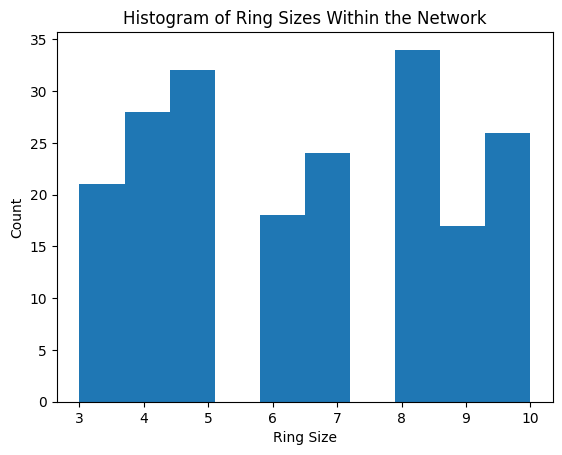

In [4]:
"""
Create histogram of ring sizes
"""
plt.hist(network.R, histtype= 'stepfilled')
plt.title("Histogram of Ring Sizes Within the Network")
plt.xlabel("Ring Size")
plt.ylabel("Count")
plt.show()

Random Seed: 197245
Ring Sizes: {3: 3, 4: 1, 5: 1, 6: 4, 7: 2, 8: 1, 9: 2, 10: 1}
{0: 6, 1: 10, 2: 9, 3: 6, 4: 4, 5: 3, 6: 8, 7: 7, 8: 9, 9: 5, 10: 6, 11: 3, 12: 3, 13: 7, 14: 6}


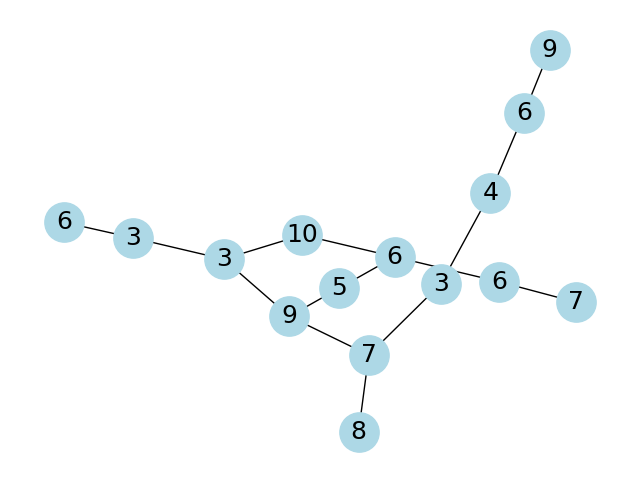

In [34]:
"""
Display Small-World Graph
"""
network2 = CoupledOscillator(n_rings = 15)
w = network2.W / network2.eps
graph = nx.from_numpy_array(w)
pos = nx.spring_layout(graph)
labels = {index : value for index, value in enumerate(network2.R)}
print(labels)
plt.figure(figsize=(8,6))
nx.draw_networkx_labels(graph, pos = pos, labels= labels, font_size= 18)
nx.draw(graph, pos = pos, node_size = 800, node_color = "lightblue")

Random Seed: 713019
Ring Sizes: {4: 1, 6: 1}


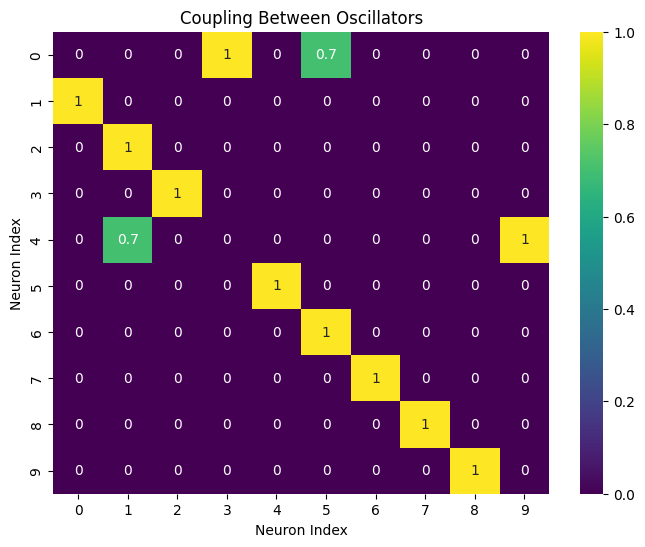

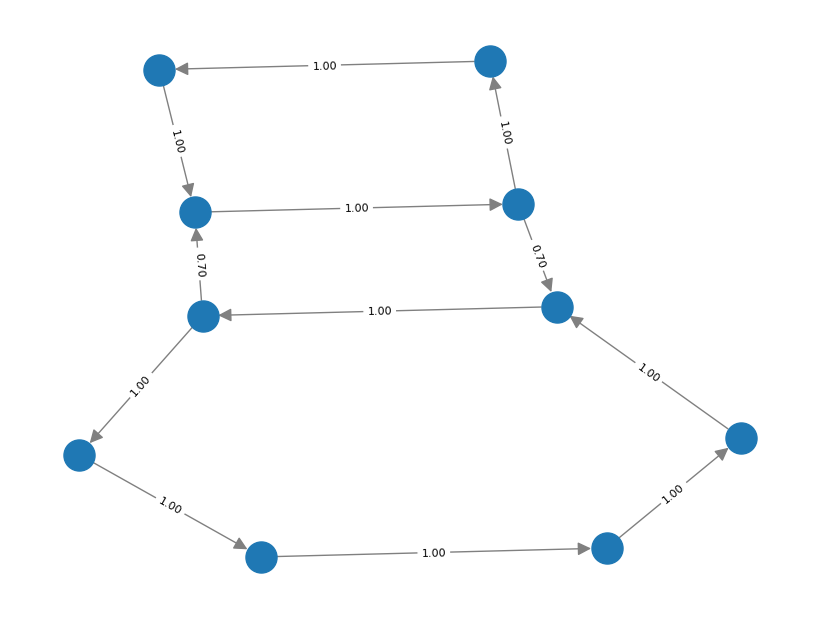

In [63]:
# Assuming CoupledOscillator is already initialized as `oscillator`
oscillator = CoupledOscillator(n_rings=2, eps = 0.7, ring_sizes=(4,6))  # Create a smaller example

# Extract W_comb for visualization
subset_rings = 2  # Visualize first 3 rings
subset_indices = np.concatenate(
    [np.arange(oscillator.nrn1_idx[i], oscillator.nrn1_idx[i] + oscillator.R[i]) for i in range(subset_rings)]
)
W_subset = oscillator.W_comb[np.ix_(subset_indices, subset_indices)]

# Visualization 1: Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(W_subset, cmap="viridis", annot=True, cbar=True)
plt.title("Coupling Between Oscillators")
plt.xlabel("Neuron Index")
plt.ylabel("Neuron Index")
plt.show()

# Visualization 2: Network Graph
G = nx.DiGraph()
for i in range(len(subset_indices)):
    for j in range(len(subset_indices)):
        if W_subset[i, j] > 0:
            G.add_edge(subset_indices[i], subset_indices[j], weight=W_subset[i, j])

pos = nx.kamada_kawai_layout(G)  

plt.figure(figsize=(8, 6))
nx.draw(
    G, pos, with_labels=False, edge_color="gray", node_size=500, font_size=10, arrowsize=20
)
nx.draw_networkx_edge_labels(
    G, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}, font_size=8
)
plt.show()

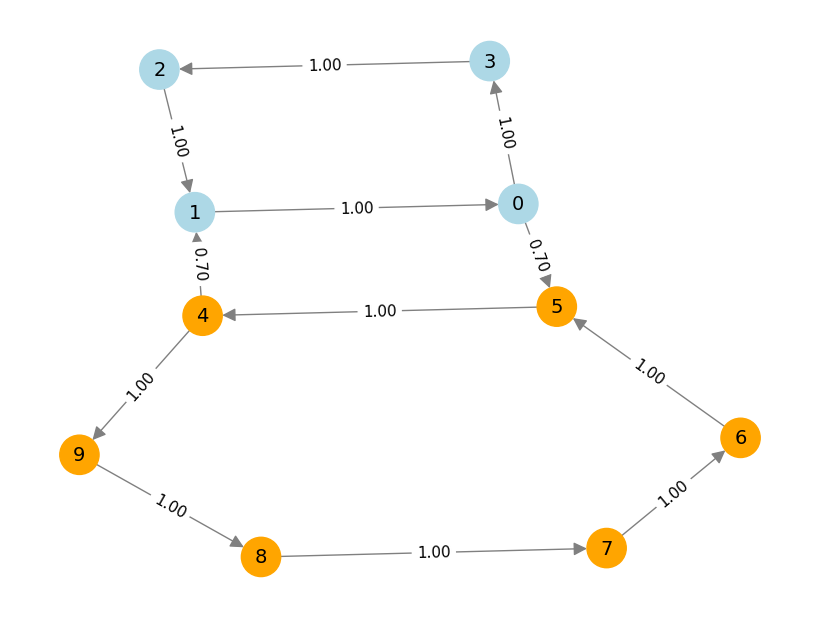

In [64]:
# Create a color mapping for rings
ring_colors = []  # List to store colors for nodes
colors = ["lightblue", "orange", "green", "pink", "purple"]  # Define a palette

for i in range(len(subset_indices)):
    # Determine the ring this neuron belongs to
    for ring_idx, (start, size) in enumerate(zip(oscillator.nrn1_idx[:subset_rings], oscillator.R[:subset_rings])):
        if start <= subset_indices[i] < start + size:
            ring_colors.append(colors[ring_idx % len(colors)])  # Cycle through colors for different rings
            break


ring_colors[4] = "lightblue"
ring_colors[2] = "orange"
# Draw the network graph
pos = nx.kamada_kawai_layout(G)  
plt.figure(figsize=(8, 6))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color=ring_colors,  # Assign colors based on rings
    edge_color="gray",
    node_size=800,
    font_size=14,
    arrowsize=20,
)
nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)},
    font_size=11,
)
plt.show()

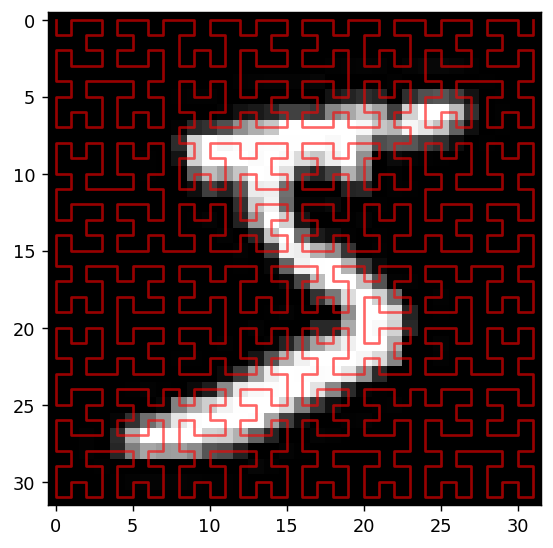

In [24]:
"""
Generate input: MNIST Data according to Hilbert Curve
Creates v_in
"""
(train_X, train_y), (test_X, test_y) = mnist.load_data()

A = train_X[0, :, :]
#Takes an mnist digit and returns a numpy array of size (n_ts, n_in)
def create_v_in(mnist_digit, n_in, n_ts):
    mnist_digit = ndimage.zoom(mnist_digit, 32/28, mode = 'constant')
    mnist_digit = mnist_digit * 0.01
    N = mnist_digit.shape[0]
    #Add some noise
    mnist_digit += 0.001 * np.random.randn(*mnist_digit.shape)
    # Hilbert curve positions
    logN = int(np.log2(N))
    locs = decode(np.arange(N**2), 2, logN)

    # Creating the sliding window embedding
    sw_dim = n_in  # Sliding window dimension
    sw = np.zeros((N**2 - sw_dim + 1,sw_dim))
    # Traversal of the image A along the Hilbert curve
    A_hilbert = mnist_digit[locs[:,0], locs[:,1]]
    # Sliding window of the Hilbert curve traversal
    for i in range(sw_dim):
        sw[:,sw_dim-i-1] = A_hilbert[i:][:sw.shape[0]]


    n, d  = sw.shape
    ratio = n_ts // n
    remainder = n_ts % n

    # Repeat each entry of sw n_in // n times
    sw_repeated = np.repeat(sw, ratio, axis=0)

    # Repeat the beginning sequences of sw to fill the remaining elements
    if remainder > 0:
        sw_remainder = sw_repeated[:remainder]
        sw_repeated = np.vstack((sw_repeated, sw_remainder))

    return sw_repeated, locs


sw_repeated, locs = create_v_in(A, network.n_in, network.n_ts)

# Visualization
plt.figure(figsize=(5,5),dpi=128)
plt.imshow(ndimage.zoom(A, 32/28, mode = 'constant'), cmap='binary_r')
plt.plot(locs[:,0], locs[:,1], c='r', alpha=0.6)
plt.show()

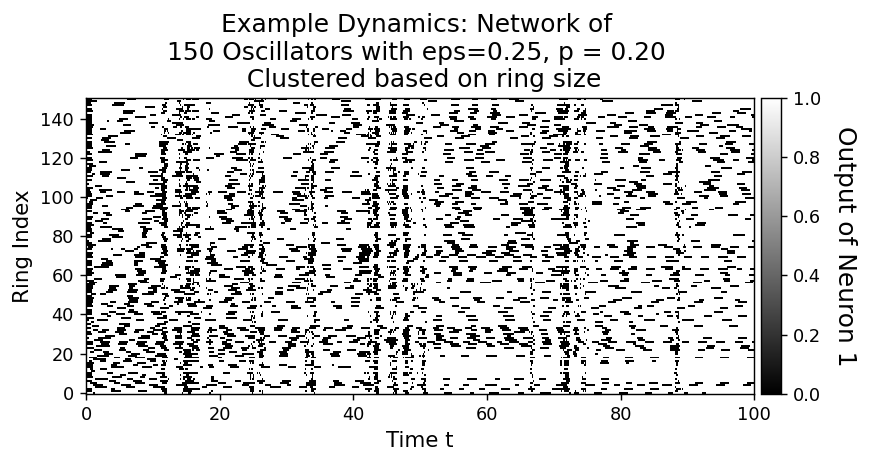

In [25]:
"""
Simulate Network
"""

v_outs, v_cap = network.simulate(sw_repeated)
network.reset()

"""
Visualization of the results ordered based on ring size
"""
nrn1_idx_unordered = network.nrn1_idx[np.argsort(network.R)]
plt.figure(figsize=(7,3), dpi=128)
plt.title('Example Dynamics: Network of \n%d Oscillators with eps=%0.2f, p = %0.2f \n Clustered based on ring size' % (network.n_rings, network.eps, network.p), size=14)
plt.xlabel('Time t', size=12)
plt.ylabel('Ring Index', size=12)
# Heatmap
im = plt.imshow(
    v_outs[:,nrn1_idx_unordered].T, 
    extent=(0,network.T_sim,-0.5,network.n_rings+0.5),
    aspect='auto', interpolation='none', vmin=0, vmax=1, cmap='binary_r',
    origin='lower'
)
# colorbar
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="3%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.ax.set_ylabel('Output of Neuron 1', size=14, rotation=-90, labelpad=20)

plt.show()

In [26]:
"""
Run simulation over training imgs to create
training set for classifier
"""
train_dataset = []
n = CoupledOscillator()
for img in train_X:
    n.initialize()
    v_in, locs = create_v_in(img, n.n_in, n.n_ts)
    outs, caps = n.simulate(v_in)
    v_os = outs[::n.n_ts//n.n_in]
    v_os = v_os.reshape(-1) 
    train_dataset.append(v_os)
    n.reset()

train_dataset = np.array(train_dataset)
np.save('train_dataset_150rings.npy', train_dataset)

Random Seed: 446758
Ring Sizes: {3: 18, 4: 22, 5: 11, 6: 17, 7: 9, 8: 27, 9: 19, 10: 27}


In [27]:
"""
Load Dataset if you don't want to re-run simulation
"""

# train_dataset = np.load('train_dataset.npy')
# test_dataset = np.load('test_dataset.npy')

"\nLoad Dataset if you don't want to re-run simulation\n"

In [28]:
"""
Train linear classifier on our training dataset
"""
print(train_dataset.shape)
classifier = RidgeClassifier(alpha = 1e-4)

train_y = (train_y > 0).astype(int)

classifier.fit(train_dataset, train_y)
predictions = classifier.predict(train_dataset)

conf_matrix = confusion_matrix(train_y, predictions)

# Calculate precision and accuracy
true_positives = conf_matrix[0, 0]   
false_positives = conf_matrix[0, 1] 
false_negatives = conf_matrix[1, 0]
true_negatives = conf_matrix[1, 1]

precision = true_positives / (true_positives + false_positives)
accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
print('Training accuracy: ', accuracy)
print('Training precision: ', precision)

print(conf_matrix)

(60000, 9171)
Training accuracy:  0.99185
Training precision:  0.9252068208678035
[[ 5480   443]
 [   46 54031]]


In [29]:
"""
Run simulation over test imgs to create
test set for classifier
"""
test_dataset = []
for img in test_X:
    n.initialize()
    v_in, locs = create_v_in(img, n.n_in, n.n_ts)
    outs, caps = n.simulate(v_in)
    v_os = outs[::n.n_ts//n.n_in]
    v_os = v_os.reshape(-1) 
    test_dataset.append(v_os)
    n.reset()

test_dataset = np.array(test_dataset)
np.save('test_dataset_150rings.npy', test_dataset)

In [30]:
"""
Compare test set performance to classifier trained on training dataset
"""
test_y = (test_y > 0).astype(int)
test_predictions = classifier.predict(test_dataset)
conf_matrix = confusion_matrix(test_y, test_predictions)

conf_matrix_test = confusion_matrix(test_y, test_predictions)
# Calculate precision and accuracy
true_positives = conf_matrix[0, 0]   
false_positives = conf_matrix[0, 1] 
false_negatives = conf_matrix[1, 0]
true_negatives = conf_matrix[1, 1]

precision = true_positives / (true_positives + false_positives)
accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

print('Test accuracy: ', accuracy)
print('Test precision: ', precision)

print(conf_matrix_test)

Test accuracy:  0.9856
Test precision:  0.8918367346938776
[[ 874  106]
 [  38 8982]]
